In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as an
import numpy as np
from numpy import random
from qutip import *
import time
import qutip as qt
import os
from datetime import datetime

import scipy as sp
import scipy.optimize
from scipy.optimize import curve_fit

import matplotlib.patches as patches

plt.rcParams['font.size'] = 15
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13

muB = 5.79e-5 #bohr magnetron in eV
h = 4.15e-15 #plank constant eV.s
hbar = h/(2*np.pi) # reduced Planck constant in eV*s
e = 1.602e-19


In [2]:
# Implement the same time dependent hamiltonian method for a 5x5 hamiltonian

#Define the magnetic fields
    # Magnetic axes x,y and z are chosen based on sample. x-y inplane. z outplane
    # theta is the in-plane angle with theta = 0 along x-axis.
    # phi is the out of plane angle with phi = 90 coresponding the z-axis.

    # We also include independent g-tensor for the left and right dot. 
    # where gxL, gyL and gzL are the observed g-factors of the left dot when B is applied along the x,y,z axis respectively

def Bx(Bmag, theta, phi):
    return Bmag * np.cos(theta) * np.cos(phi)

def By(Bmag, theta, phi):
    return Bmag * np.sin(theta) * np.cos(phi)

def Bz(Bmag, theta, phi):
    return Bmag * np.sin(phi)

def Hz( theta, phi, Bmag, glxx, glxy, glxz, glyy, glyz, glzz, grxx, grxy, grxz, gryy, gryz, grzz):
    mu = 5.79e-5
    glyx = glxy
    glzx = glxz
    glzy = glyz
    gryx = grxy
    grzx = grxz
    grzy = gryz
    
    Bxx = Bx(Bmag, theta, phi)
    Byy = By(Bmag, theta, phi)
    Bzz = Bz(Bmag, theta, phi)
    
    result = np.zeros((5, 5), dtype=complex)
    
    result[0, 0] = 1/2 * (Bxx * (glxz + grxz) + Byy * (glyz + gryz) + Bzz * (glzz + grzz)) * mu
    result[0, 1] = ((Bxx * (glxx - 1j * (glxy + 1j * grxx + grxy)) + Byy * (glyx - 1j * glyy + gryx - 1j * gryy) + Bzz * (glzx - 1j * glzy + grzx - 1j * grzy)) * mu) / (2 * np.sqrt(2))
    result[0, 2] = 0
    result[0, 3] = -(((Bxx * (glxx - 1j * glxy - grxx + 1j * grxy) + Byy * (glyx - 1j * glyy - gryx + 1j * gryy) + Bzz * (glzx - 1j * glzy - grzx + 1j * grzy)) * mu) / (2 * np.sqrt(2)))
    result[0, 4] = 0
    
    result[1, 0] = ((Bxx * (glxx + 1j * glxy + grxx + 1j * grxy) + Byy * (glyx + 1j * glyy + gryx + 1j * gryy) + Bzz * (glzx + 1j * glzy + grzx + 1j * grzy)) * mu) / (2 * np.sqrt(2))
    result[1, 1] = 0
    result[1, 2] = ((Bxx * (glxx - 1j * (glxy + 1j * grxx + grxy)) - Byy * (glyx - 1j * glyy + gryx - 1j * gryy) + Bzz * (glzx - 1j * glzy + grzx - 1j * grzy)) * mu) / (2 * np.sqrt(2))
    result[1, 3] = 1/2 * (Bxx * (glxz - grxz) + Byy * (glyz - gryz) + Bzz * (glzz - grzz)) * mu
    result[1, 4] = 0
    
    result[2, 0] = 0
    result[2, 1] = ((Bxx * (glxx + 1j * glxy + grxx + 1j * grxy) - Byy * (glyx + 1j * glyy + gryx + 1j * gryy) + Bzz * (glzx + 1j * glzy + grzx + 1j * grzy)) * mu) / (2 * np.sqrt(2))
    result[2, 2] = -1/2 * (Bxx * (glxz + grxz) + Byy * (glyz + gryz) + Bzz * (glzz + grzz)) * mu
    result[2, 3] = ((Bxx * (glxx + 1j * (glxy + 1j * grxx - grxy)) + Byy * (glyx + 1j * glyy - gryx - 1j * gryy) + Bzz * (glzx + 1j * glzy - grzx - 1j * grzy)) * mu) / (2 * np.sqrt(2))
    result[2, 4] = 0
    
    result[3, 0] = -((Bxx * (glxx + 1j * (glxy + 1j * grxx - grxy)) + Byy * (glyx + 1j * glyy - gryx - 1j * gryy) + Bzz * (glzx + 1j * glzy - grzx - 1j * grzy)) * mu) / (2 * np.sqrt(2))
    result[3, 1] = 1/2 * (Bxx * (glxz - grxz) + Byy * (glyz - gryz) + Bzz * (glzz - grzz)) * mu
    result[3, 2] = ((Bxx * (glxx - 1j * glxy - grxx + 1j * grxy) + Byy * (glyx - 1j * glyy - gryx + 1j * gryy) + Bzz * (glzx - 1j * glzy - grzx + 1j * grzy)) * mu) / (2 * np.sqrt(2))
    result[3, 3] = 0
    result[3, 4] = 0
    
    result[4, 0] = 0
    result[4, 1] = 0
    result[4, 2] = 0
    result[4, 3] = 0
    result[4, 4] = 0
    
    return result

#Define the orbital Hamiltonian
    #tc is the tunnel coupling in eV
    #epsilon is the detuning in eV

def Horb(epsilon, tc):
    return np.array([
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, np.sqrt(2) * tc],
        [0, 0, 0, np.sqrt(2) * tc, epsilon]
    ])

#Define function for Spin orbit Hamiltonian
    #tx,ty,tz are the components of the spin orbit vector projected along the magnetic x,y, and z axes.
def Omega_p(tx, ty):
    return tx + 1j * ty

def Omega_m(tx, ty):
    return tx - 1j * ty

def Omega_pDag(tx, ty):
    return tx - 1j * ty

def Omega_mDag(tx, ty):
    return tx + 1j * ty

def Hso(tx, ty, tz):
    return np.array([
        [0, Omega_p(tx, ty), 0, -Omega_mDag(tx, ty), tz],
        [Omega_pDag(tx, ty), 0, Omega_p(tx, ty), 0, 0],
        [0, Omega_pDag(tx, ty), 0, Omega_m(tx, ty), tz],
        [-Omega_m(tx, ty), 0, Omega_mDag(tx, ty), 0, 0],
        [tz, 0, tz, 0, 0]
    ])

#Construct the full Hamiltonian.
def getH(epsilon, tc, theta, phi, Bmag, glxx, glxy, glxz, glyy, glyz, glzz, grxx, grxy, grxz, gryy, gryz, grzz, tx, ty, tz):
    return Qobj(Hz(theta, phi, Bmag, glxx, glxy, glxz, glyy, glyz, glzz, grxx, grxy, grxz, gryy, gryz, grzz) + Horb(epsilon, tc) + Hso(tx, ty, tz))

#extract all eigenenergies as real components, ordered in decending order based on amplitude.
def extract_eigenenergies(epsilon, tc, theta, phi, Bmag, glxx, glxy, glxz, glyy, glyz, glzz, grxx, grxy, grxz, gryy, gryz, grzz, tx, ty, tz):
    H = getH(epsilon, tc, theta, phi, Bmag, glxx, glxy, glxz, glyy, glyz, glzz, grxx, grxy, grxz, gryy, gryz, grzz, tx, ty, tz)
    eigenvalues, _ = np.linalg.eig(H)
    real_eigenvalues = np.real(eigenvalues)  # Extract the real component of eigenvalues
    sorted_eigenvalues = np.sort(real_eigenvalues)[::-1]  # Sort eigenvalues in descending order
    return sorted_eigenvalues

def extract_eigenenergies_and_vectors(epsilon, tc, theta, phi, Bmag, glxx, glxy, glxz, glyy, glyz, glzz, grxx, grxy, grxz, gryy, gryz, grzz, tx, ty, tz):
    H = getH(epsilon, tc, theta, phi, Bmag, glxx, glxy, glxz, glyy, glyz, glzz, grxx, grxy, grxz, gryy, gryz, grzz, tx, ty, tz)
    eigenvalues, eigenvectors = np.linalg.eig(H)
    real_eigenvalues = np.real(eigenvalues)  # Extract the real component of eigenvalues
    sorted_indices = np.argsort(real_eigenvalues)[::-1]  # Sort eigenvalues in descending order and get the corresponding indices

    sorted_eigenvalues = real_eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]

    # Convert eigenvectors to Qutip quantum objects
    qutip_eigenvectors = [qt.Qobj(vec) for vec in sorted_eigenvectors.T]

    return sorted_eigenvalues, qutip_eigenvectors

# The same eps_ramp and H_t functions are used from the very first simulation
def eps_ramp(e0, ef, ramp_time, t):
    """Linear detuning ramp function e(t)
    
    Args: 
        e0: initial detuning
        ef: final detuning
        ramp_time: pre-defined ramp time
        t: current time (from t=0 initialisation)
    """

    eps_t = e0 + t*(ef-e0)/ramp_time
    
    return eps_t

def H_t(t,args):
    """Time dependent hamiltonian to be input into qutip.sesolve()
    
    Args:
        t: automatically input by qutip.sesolve() time vector
        args (dictionary): variables used in hamiltonian, set inside qutip.sesovle() argumnents
    """
    # Set variables form args dictionary
    e0 = args['e0']
    ef = args['ef']
    ramp_time = args['ramp_time']
    Bmag = args['B']
    theta = args['theta']
    #tc = args['tc']
    
    # Get e(t) and calculate hamiltonian
    eps_t = eps_ramp(e0,ef,ramp_time, t)
    H = getH(eps_t, tc, theta, phi, Bmag, glxx, glxy, glxz, glyy, glyz, glzz, grxx, grxy, grxz, gryy, gryz, grzz, tx, ty, tz)/hbar
    #print('glxx = ', glxx)
    return H


def extract_freq2(x, tc, glxx, glxy, glxz, glyy, glyz, glzz, grxx, grxy, grxz, gryy, gryz, grzz, tx, ty):
    tz = 0

    num = len(x)
    for i in range(num):
        epsilon = x[:,0]
        Bmag = x[:,1]
        theta = x[:,2]
        phi = x[:,3]
        levels = extract_eigenenergies(epsilon[i], tc, theta[i], phi[i], Bmag[i], glxx, glxy, glxz, glyy, glyz, glzz, grxx, grxy, grxz, gryy, gryz, grzz, tx, ty, tz)
        LZ = levels[3]-levels[4]
        ST = levels[2]-levels[3]
        Total = levels[2]-levels[4]
        freqs = [Total,LZ,ST]
        if i==0:
            fout = freqs
        else:
            fout = np.row_stack((fout,freqs))    
    return fout

# Define the model function to fit
def model_function(x, tc, glxx, glxy, glxz, glyy, glyz, glzz, grxx, grxy, grxz, gryy, gryz, grzz, tx, ty):
    return extract_freq2(x, tc, glxx, glxy, glxz, glyy, glyz, glzz, grxx, grxy, grxz, gryy, gryz, grzz, tx, ty).flatten()


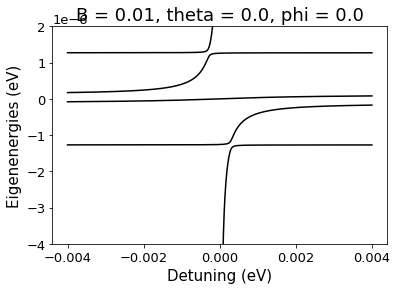

In [3]:
import matplotlib.pyplot as plt

#plot the eigenenergies for some situations.
epsilon = 0.0

# Parameters for the first plot
#Bx --> theta = 0, phi = 0
#By --> theta = 90, phi = 0
#Bz --> phi = 90
theta = ((0)*np.pi)/180
phi = 0*np.pi/2
Bmag = 0.01

#best fit parameters. 
tc = 1.37e-05
tx = -3.69e-08
ty = 1.07e-07
tz = 0.00e+00
glxx = -0.783
glxy = -1.129
glxz = -1.449
glyy = 0.852
glyz = -0.269
glzz = 1.905
grxx = -0.957
grxy = -0.939
grxz = -1.473
gryy = 0.776
gryz = -0.739
grzz = 1.819

#Test with some other best fir g-tensors and SO
# tc = 1.21e-05
# tx = -1.96e-09
# ty = 3.75e-09
# tz = 0.00e+00
# glxx = -1.189
# glxy = -0.709
# glxz = -0.867
# glyy = 0.528
# glyz = -0.277
# glzz = 1.735
# grxx = -1.510
# grxy = -0.774
# grxz = -1.042
# gryy = 1.014
# gryz = -0.380
# grzz = 1.851

detuning_range = np.linspace(-4e-3, 4e-3, 2000)

eigenenergies = []

for e in detuning_range:
    eigenvalues = extract_eigenenergies(e, tc, theta, phi, Bmag, glxx, glxy, glxz, glyy, glyz, glzz, grxx, grxy, grxz, gryy, gryz, grzz, tx, ty, tz)
    eigenenergies.append(eigenvalues)

eigenenergies = np.array(eigenenergies)

for i in range(eigenenergies.shape[1]):
    plt.plot(detuning_range, eigenenergies[:, i], color='black', label="Level {}".format(i+1))
    
plt.xlabel("Detuning (eV)")
plt.ylabel("Eigenenergies (eV)")
#plt.legend()
plt.ylim(-4e-6, 2e-6)
plt.title("B = " + str(Bmag) + ", theta = "+ str(theta) + ", phi = "+ str(phi))
plt.show()

# Uncomment to save data
# np.savetxt(folderOut + '/optimal_Bx_10mT_E.csv', eigenenergies[:, :], delimiter=',')
# np.savetxt(folderOut + '/optimal_Bx_10mT_eps.csv', detuning_range, delimiter=',')

In [8]:
# Below is the code used to simulate the singlet-triplet experiment results.
# this includes simulating the ramp-in to accurate calculate the state mixing caused by the avoided crossing
# and also the hold time where singlet-triplet evolution occurs. 

# Define Experimental Parameters
eI = -5e-3
e0 = -1.5e-3
ef = 2e-3

theta = 0
phi = 0

tc = 1.37e-05
tx = -3.69e-08
ty = 1.07e-07
tz = 0.00e+00
glxx = -0.783
glxy = -1.129
glxz = -1.449
glyy = 0.852
glyz = -0.269
glzz = 1.905
grxx = -0.957
grxy = -0.939
grxz = -1.473
gryy = 0.776
gryz = -0.739
grzz = 1.819

# tc = 1.26e-05 
# tx = -7.05e-08 
# ty = 2.62e-08 
# tz = 0.00e+00 
# glxx = 0.321 
# glxy = 0.342 
# glxz = -1.628 
# glyy = -0.604 
# glyz = -0.805 
# glzz = -0.153 
# grxx = 0.343 
# grxy = 0.603 
# grxz = -1.901 
# gryy = -1.151 
# gryz = -0.790 
# grzz = -0.857

h = 4.13e-15 #Planck's constant (eV*s)
hbar = h/(2*np.pi) #Reduced Planck's constant (eV*s)

#Input the measurement parameters
ramp_time = 4e-9
times = np.linspace(0,ramp_time,1000)
B = 10e-3

# Adding a further hold time 
hold_time = 60e-9
tau_s = np.linspace(0,hold_time,3000) #Hold-time

# Loop over theta values
num_theta_values = 36
theta_values = np.linspace(0, np.pi, num_theta_values)

# Create an empty 3D array to store evals_hold results for different theta values
evals_all_theta = np.zeros((len(times), 5, num_theta_values))

# Create an empty 3D array to store evals_hold results for different theta values
evals_hold_all_theta = np.zeros((len(tau_s), 5, num_theta_values))

# Run loop over all the theta values
for i_theta, theta_value in enumerate(theta_values):
    # Your code to simulate ramp and hold for the current theta value
    print(i_theta+1, 'of ',num_theta_values) 
    theta = theta_value
    evals = np.zeros((len(times), 5))
    

#Determine the eigenstates at the initial and separation detuning (ef)
    Initial_e, Initial_vecs = extract_eigenenergies_and_vectors(eI, tc, theta, phi, B, glxx, glxy, glxz, glyy, glyz, glzz, grxx, grxy, grxz, gryy, gryz, grzz, tx, ty, tz)    
    Final_e, Final_vecs = extract_eigenenergies_and_vectors(ef, tc, theta, phi, B, glxx, glxy, glxz, glyy, glyz, glzz, grxx, grxy, grxz, gryy, gryz, grzz, tx, ty, tz)    
    
    #Define the eigenstates at the initial detuning.
    #These should be very close to the basis vectors of the matrix (since we define H in Singlet-Triplet basis)
    S02 = Initial_vecs[4]
    T_p = Initial_vecs[0]
    T_0 = Initial_vecs[1]
    T_m = Initial_vecs[3]
    S11 = Initial_vecs[2]
    
#     S02 = Qobj([[0], [0], [0], [0],[1]])
#     T_p = Qobj([[1], [0], [0], [0],[0]])
#     T_0 = Qobj([[0], [1], [0], [0],[0]])
#     T_m = Qobj([[0], [0], [1], [0],[0]])
#     S11 = Qobj([[0], [0], [0], [1],[0]])
    
    #initialise in the lowest energy eigenstate at the initial detuning
    #This will be the S02 state.
    psi0 = S02
    
    #For later use we also define the eigenstates at the separation detuning (ef).
    #This assumes Ez > J which should be true for most cases (ie Tm is lowest energy)
    S02f = Final_vecs[0]
    T_pf = Final_vecs[1]
    T_0f = Final_vecs[2]
    T_mf = Final_vecs[4]
    S11f = Final_vecs[3]
    
    #Time evolve the psi0 = S02 to siumulate the ramp in.
    result = sesolve(H_t, psi0, times, [], args={'ramp_time': ramp_time, 'e0': e0,'ef' : ef, 'B': B,'theta':theta},\
                           options=Options(nsteps=10000))
    
    #Project the state at the end of the ramp onto each of the initial eigenvectors.
    evals = np.zeros((len(times), 5))
    evals[:,0] = [expect(S02*S02.dag(), s) for s in result.states]
    evals[:,1] = [expect(S11*S11.dag(), s) for s in result.states]
    evals[:,2] = [expect(T_0*T_0.dag(),s) for s in result.states]
    evals[:,3] = [expect(T_m*T_m.dag(),s) for s in result.states]
    evals[:,4] = [expect(T_p*T_p.dag(),s) for s in result.states]

    # Store evals_hold for the current theta value in the 3D array
    evals_all_theta[:, :, i_theta] = evals

    result_up = result
    
    #Use the final state from the ramp and simulate a hold at the separation point.
    psi1 = result_up.states[-1]

    result_hold = sesolve(getH(ef, tc, theta, phi, B, glxx, glxy, glxz, glyy, glyz, glzz, grxx, grxy, grxz, gryy, gryz, grzz, tx, ty, tz)/hbar, psi1, tau_s, [], options=Options(nsteps=10000))

    evals_hold = np.zeros((len(tau_s), 5))

    evals_hold[:,0] = [expect(S02*S02.dag(), s) for s in result_hold.states]
    evals_hold[:,1] = [expect(S11*S11.dag(), s) for s in result_hold.states]
    evals_hold[:,2] = [expect(T_0*T_0.dag(),s) for s in result_hold.states]
    evals_hold[:,3] = [expect(T_m*T_m.dag(),s) for s in result_hold.states]
    evals_hold[:,4] = [expect(T_p*T_p.dag(),s) for s in result_hold.states]

    # Store evals_hold for the current theta value in the 3D array
    evals_hold_all_theta[:, :, i_theta] = evals_hold

print('Simulation finished.')    
    #You can also simulate a final ramp out. It makes the results more aligned to the experiment, however significatly increses the compation time.
    #This is because for every hold time you need to simulatea specific ramp out, and the ramp out is the longest aspect of this sim.
    #In practice we have found the quantitative results do not vary significantly. However we have performed both. 
    #See code SimA for the full scale protocol. 
    

# Uncomment to save data
# np.savetxt(folderOut + '/optimal_10mT_hold_S02.csv', evals_hold_all_theta[:, 0, :], delimiter=',')
# np.savetxt(folderOut +'/optimal_10mT_hold_S11.csv', evals_hold_all_theta[:, 1, :], delimiter=',')
# np.savetxt(folderOut +'/optimal_10mT_hold_T0.csv', evals_hold_all_theta[:, 2, :], delimiter=',')
# np.savetxt(folderOut +'/optimal_10mT_hold_Tm.csv', evals_hold_all_theta[:, 3, :], delimiter=',')
# np.savetxt(folderOut +'/optimal_10mT_hold_Tp.csv', evals_hold_all_theta[:, 4, :], delimiter=',')
# np.savetxt(folderOut +'/optimal_hold_theta.csv', theta_values, delimiter=',')
# np.savetxt(folderOut +'/tau_s.csv', tau_s, delimiter=',')

# np.savetxt(folderOut +'/optimal_10mT_ramp_S02.csv', evals_all_theta[:, 0, :], delimiter=',')
# np.savetxt(folderOut +'/optimal_10mT_ramp_S11.csv', evals_all_theta[:, 1, :], delimiter=',')
# np.savetxt(folderOut +'/optimal_10mT_ramp_T0.csv', evals_all_theta[:, 2, :], delimiter=',')
# np.savetxt(folderOut +'/optimal_10mT_ramp_Tm.csv', evals_all_theta[:, 3, :], delimiter=',')
# np.savetxt(folderOut +'/optimal_10mT_ramp_Tp.csv', evals_all_theta[:, 4, :], delimiter=',')
# np.savetxt(folderOut +'/rampTime.csv', times, delimiter=',')


1 of  36
2 of  36
3 of  36
4 of  36
5 of  36
6 of  36
7 of  36
8 of  36
9 of  36
10 of  36
11 of  36
12 of  36
13 of  36
14 of  36
15 of  36
16 of  36
17 of  36
18 of  36
19 of  36
20 of  36
21 of  36
22 of  36
23 of  36
24 of  36
25 of  36
26 of  36
27 of  36
28 of  36
29 of  36
30 of  36
31 of  36
32 of  36
33 of  36
34 of  36
35 of  36
36 of  36
Simulation finished.


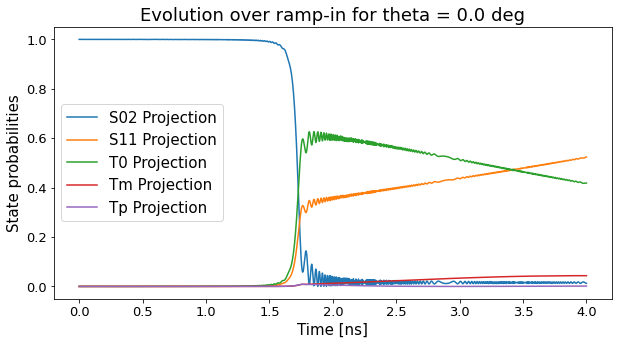

In [9]:
#Plot the states during the ramp in for a specific field orientation

th_index = 0;
plt.figure(figsize=(10,5))
plt.plot(times*1e9, evals_all_theta[:,0,th_index], label='S02 Projection')
plt.plot(times*1e9, evals_all_theta[:,1,th_index], label='S11 Projection')
plt.plot(times*1e9, evals_all_theta[:,2,th_index], label='T0 Projection')
plt.plot(times*1e9, evals_all_theta[:,3,th_index], label='Tm Projection')
plt.plot(times*1e9, evals_all_theta[:,4,th_index], label='Tp Projection')
plt.legend(loc='center left')
plt.xlabel('Time [ns]')
plt.ylabel('State probabilities')
plt.title('Evolution over ramp-in for theta = ' + str(np.round(theta_values[th_index]*180/np.pi,1 ))+ ' deg' )
plt.show()

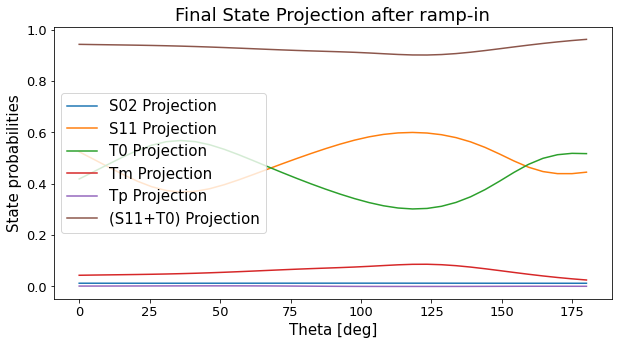

In [10]:
#Plot the final states after the ramp in as a function of field orientation

plt.figure(figsize=(10,5))
plt.plot(theta_values*180/np.pi, evals_all_theta[-1,0,:], label='S02 Projection')
plt.plot(theta_values*180/np.pi, evals_all_theta[-1,1,:], label='S11 Projection')
plt.plot(theta_values*180/np.pi, evals_all_theta[-1,2,:], label='T0 Projection')
plt.plot(theta_values*180/np.pi, evals_all_theta[-1,3,:], label='Tm Projection')
plt.plot(theta_values*180/np.pi, evals_all_theta[-1,4,:], label='Tp Projection')
plt.plot(theta_values*180/np.pi, evals_all_theta[-1,1,:]+evals_all_theta[-1,2,:], label='(S11+T0) Projection')
plt.legend(loc='center left')
plt.xlabel('Theta [deg]')
plt.ylabel('State probabilities')
plt.title('Final State Projection after ramp-in')
plt.show()

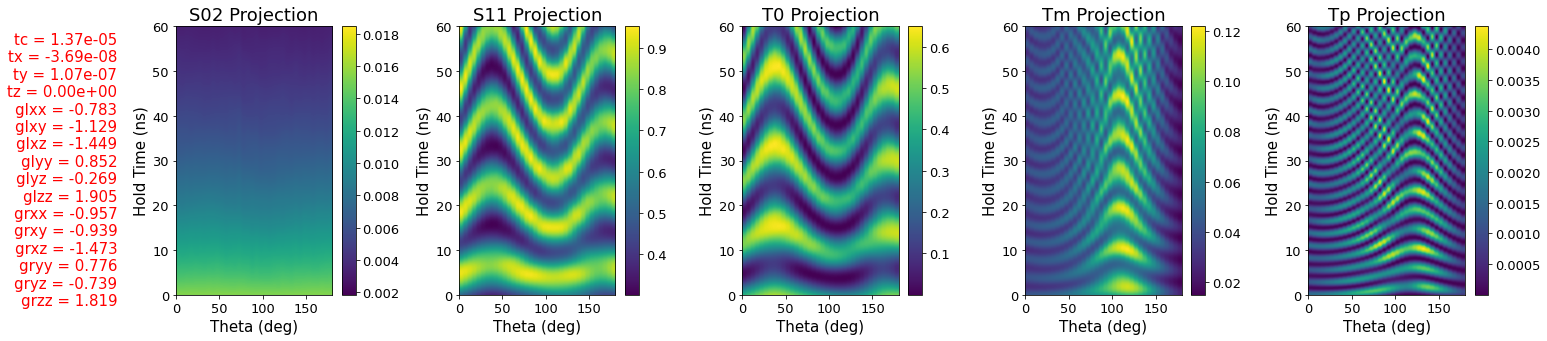

In [11]:
# Finally plot the state evolution during the hold time to see the singlet triplet oscillations. 

# Create a 2x5 grid for plots of raw data and FFT
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

param_text = f"tc = {tc:.2e}\n" \
             f"tx = {tx:.2e}\n" \
             f"ty = {ty:.2e}\n" \
             f"tz = {tz:.2e}\n" \
             f"glxx = {glxx:.3f}\n" \
             f"glxy = {glxy:.3f}\n" \
             f"glxz = {glxz:.3f}\n" \
             f"glyy = {glyy:.3f}\n" \
             f"glyz = {glyz:.3f}\n" \
             f"glzz = {glzz:.3f}\n" \
             f"grxx = {grxx:.3f}\n" \
             f"grxy = {grxy:.3f}\n" \
             f"grxz = {grxz:.3f}\n" \
             f"gryy = {gryy:.3f}\n" \
             f"gryz = {gryz:.3f}\n" \
             f"grzz = {grzz:.3f}"

# Define title strings
titlestr = ['S02', 'S11', 'T0', 'Tm', 'Tp']

# Loop over energy levels (columns) of evals_hold
for i_col in range(5):
    # Plot raw data in the corresponding subplot
    ax_raw_data = axes[i_col]
    ax_raw_data.imshow(evals_hold_all_theta[:, i_col, :], aspect='auto', cmap='viridis', origin='lower',
                       extent=[np.min(theta_values)*180/np.pi, np.max(theta_values)*180/np.pi, 0, hold_time*10**9])
    ax_raw_data.set_xlabel("Theta (deg)")
    ax_raw_data.set_ylabel("Hold Time (ns)")
    ax_raw_data.set_title(f"{titlestr[i_col]} Projection")
    fig.colorbar(ax_raw_data.images[0], ax=ax_raw_data)

plt.tight_layout()

plt.figtext(0, 0.5, param_text, va="center", ha="right",color='red')

plt.show()